## **Installing packages**

In [1]:
!pip install pyvirtualdisplay
!pip install swig
!pip install gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 60.8 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373078 sha256=e6f5c334e89d163c526dc41da4c297729eec4ab074fe92759cbac4c1121bafff
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


## **Importing necessary libraries**

In [2]:
import time
from collections import deque, namedtuple
import gym
import numpy as np
import PIL.Image
import tensorflow as tf
from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
import base64
import random
import imageio
import IPython
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd


## **Utils Functions**

In [3]:
def plot_history(point_history, **kwargs):
    lower_limit = 0
    upper_limit = len(point_history)
    window_size = (upper_limit * 10) // 100

    plot_rolling_mean_only = False
    plot_data_only = False

    if kwargs:
        window_size = kwargs.get("window_size", window_size)
        lower_limit = kwargs.get("lower_limit", lower_limit)
        upper_limit = kwargs.get("upper_limit", upper_limit)
        plot_rolling_mean_only = kwargs.get("plot_rolling_mean_only", False)
        plot_data_only = kwargs.get("plot_data_only", False)

    points = point_history[lower_limit:upper_limit]
    episode_num = [x for x in range(lower_limit, upper_limit)]
    rolling_mean = pd.DataFrame(points).rolling(window_size).mean()

    plt.figure(figsize=(10, 7), facecolor="white")

    if plot_data_only:
        plt.plot(episode_num, points, linewidth=1, color="cyan")
    elif plot_rolling_mean_only:
        plt.plot(episode_num, rolling_mean, linewidth=2, color="magenta")
    else:
        plt.plot(episode_num, points, linewidth=1, color="cyan")
        plt.plot(episode_num, rolling_mean, linewidth=2, color="magenta")

    text_color = "black"
    ax = plt.gca()
    ax.set_facecolor("black")
    plt.grid()
    plt.xlabel("Episode", color=text_color, fontsize=30)
    plt.ylabel("Total Points", color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter("{x:,}")
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis="x", colors=text_color)
    ax.tick_params(axis="y", colors=text_color)
    plt.show()



def embed_mp4(filename):
    video = open(filename, "rb").read()
    b64 = base64.b64encode(video)
    tag = """
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>""".format(
        b64.decode()
    )
    return IPython.display.HTML(tag)

def create_video(filename, env, q_network, fps=30):
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        state = env.reset()
        frame = env.render(mode="rgb_array")
        video.append_data(frame)
        while not done:
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
            state, _, done, _ = env.step(action)
            frame = env.render(mode="rgb_array")
            video.append_data(frame)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Model and Agent necessary function**

In [4]:
ALPHA = 1e-3

env = gym.make('LunarLander-v2')
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)
current_state = env.reset()


q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
])

target_q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
])

optimizer = Adam(learning_rate=ALPHA)

experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

@tf.function
def compute_loss(experiences, gamma, q_network, target_q_network):
    states, actions, rewards, next_states, done_vals = experiences
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    y_targets = rewards + gamma * max_qsa * (1 - done_vals)
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
    loss = MSE(y_targets, q_values)
    return loss

@tf.function
def agent_learn(experiences, gamma):
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    gradients = tape.gradient(loss, q_network.trainable_variables)
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))
    update_target_network(q_network, target_q_network)



def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(
        np.array([e.state for e in experiences if e is not None]), dtype=tf.float32
    )
    actions = tf.convert_to_tensor(
        np.array([e.action for e in experiences if e is not None]), dtype=tf.float32
    )
    rewards = tf.convert_to_tensor(
        np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32
    )
    next_states = tf.convert_to_tensor(
        np.array([e.next_state for e in experiences if e is not None]), dtype=tf.float32
    )
    done_vals = tf.convert_to_tensor(
        np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
        dtype=tf.float32,
    )
    return (states, actions, rewards, next_states, done_vals)

def check_update_conditions(t, num_steps_upd, memory_buffer):
    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False

def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY * epsilon)

def get_action(q_values, epsilon=0.0):
    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(4))

def update_target_network(q_network, target_q_network):
    for target_weights, q_net_weights in zip(
        target_q_network.weights, q_network.weights
    ):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


State Shape: (8,)
Number of actions: 4


## **Training**

Episode 99 | Total point average of the last 100 episodes: -153.17

Episode 100 | Total point average of the last 100 episodes: -153.07
Episode 199 | Total point average of the last 100 episodes: -78.38

Episode 200 | Total point average of the last 100 episodes: -78.55
Episode 299 | Total point average of the last 100 episodes: -42.82

Episode 300 | Total point average of the last 100 episodes: -41.68
Episode 399 | Total point average of the last 100 episodes: -11.94

Episode 400 | Total point average of the last 100 episodes: -11.35
Episode 499 | Total point average of the last 100 episodes: 102.54

Episode 500 | Total point average of the last 100 episodes: 104.46
Episode 599 | Total point average of the last 100 episodes: 200.02

Episode 600 | Total point average of the last 100 episodes: 200.06
Episode 699 | Total point average of the last 100 episodes: 231.35

Episode 700 | Total point average of the last 100 episodes: 232.13
Episode 799 | Total point average of the last 100 episodes: 239.26

Episode 800 | Total point average of the last 100 episodes: 238.94
Episode 899 | Total point average of the last 100 episodes: 258.69

Episode 900 | Total point average of the last 100 episodes: 258.72
Episode 999 | Total point average of the last 100 episodes: 263.28

Episode 1000 | Total point average of the last 100 episodes: 263.45
Episode 1099 | Total point average of the last 100 episodes: 263.46

Episode 1100 | Total point average of the last 100 episodes: 263.43
Episode 1199 | Total point average of the last 100 episodes: 262.97

Episode 1200 | Total point average of the last 100 episodes: 262.96
Episode 1299 | Total point average of the last 100 episodes: 267.60

Episode 1300 | Total point average of the last 100 episodes: 267.89
Episode 1399 | Total point average of the last 100 episodes: 252.92

Episode 1400 | Total point average of the last 100 episodes: 252.69
Episode 1499 | Total point average of the last 100 episodes: 275.24

Episode 1500 | Total point average of the last 100 episodes: 275.35
Episode 1599 | Total point average of the last 100 episodes: 273.47

Episode 1600 | Total point average of the last 100 episodes: 273.35
Episode 1699 | Total point average of the last 100 episodes: 252.13

Episode 1700 | Total point average of the last 100 episodes: 252.14
Episode 1799 | Total point average of the last 100 episodes: 269.18

Episode 1800 | Total point average of the last 100 episodes: 269.16
Episode 1899 | Total point average of the last 100 episodes: 280.45

Episode 1900 | Total point average of the last 100 episodes: 280.51
Episode 1999 | Total point average of the last 100 episodes: 268.28

Episode 2000 | Total point average of the last 100 episodes: 268.45


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Total Runtime: 3353.36 s (55.89 min)


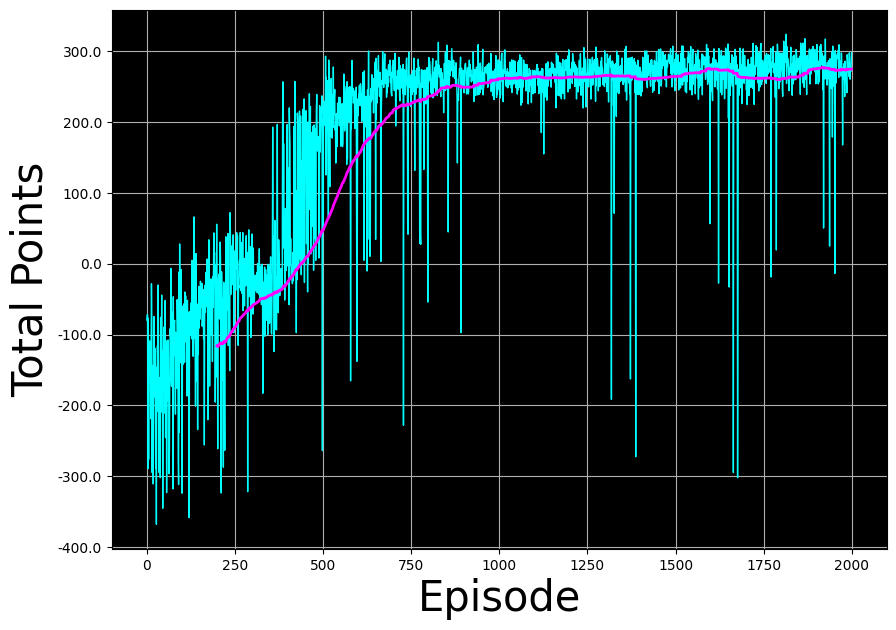

In [6]:
SEED = 0
MINIBATCH_SIZE = 64
TAU = 1e-3
E_DECAY = 0.995
E_MIN = 0.01
MEMORY_SIZE = 100_000
GAMMA = 0.995
NUM_STEPS_FOR_UPDATE = 4
num_episodes = 2000
max_num_timesteps = 1000
total_point_history = []
num_p_av = 100
epsilon = 1.0
random.seed(SEED)

start = time.time()
memory_buffer = deque(maxlen=MEMORY_SIZE)
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    state = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):
        state_qn = np.expand_dims(state, axis=0)
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)

        next_state, reward, done, _ = env.step(action)

        memory_buffer.append(experience(state, action, reward, next_state, done))

        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            experiences = get_experiences(memory_buffer)
            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")
    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")
        filename = f"./lunar_lander{i+1}.mp4"
        create_video(filename, env, q_network)
        embed_mp4(filename)
q_network.save('lunar_lander_model.h5')
tot_time = time.time() - start
print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")
plot_history(total_point_history)
import logging
logging.getLogger().setLevel(logging.ERROR)

